In [1]:
f = "1906_rental.json"
# use multiline because each json record is split into many lines as can be seen in notepad++
df = spark.read.format("json").option("multiLine", True).option("header" , "true").option("inferSchema", "true").load(f)



In [2]:
df.printSchema()

root
 |-- Result: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- project: string (nullable = true)
 |    |    |-- rental: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- areaSqft: string (nullable = true)
 |    |    |    |    |-- areaSqm: string (nullable = true)
 |    |    |    |    |-- district: string (nullable = true)
 |    |    |    |    |-- leaseDate: string (nullable = true)
 |    |    |    |    |-- noOfBedRoom: string (nullable = true)
 |    |    |    |    |-- propertyType: string (nullable = true)
 |    |    |    |    |-- rent: long (nullable = true)
 |    |    |-- street: string (nullable = true)
 |    |    |-- x: string (nullable = true)
 |    |    |-- y: string (nullable = true)
 |-- Status: string (nullable = true)



In [3]:
# Now we want to explode 2 times to enter into developerSales so later we get the dataframe at developerSales level
from pyspark.sql.functions import explode

df2 = df.select(explode(df.Result).alias("R"))
df2.printSchema()



root
 |-- R: struct (nullable = true)
 |    |-- project: string (nullable = true)
 |    |-- rental: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- areaSqft: string (nullable = true)
 |    |    |    |-- areaSqm: string (nullable = true)
 |    |    |    |-- district: string (nullable = true)
 |    |    |    |-- leaseDate: string (nullable = true)
 |    |    |    |-- noOfBedRoom: string (nullable = true)
 |    |    |    |-- propertyType: string (nullable = true)
 |    |    |    |-- rent: long (nullable = true)
 |    |-- street: string (nullable = true)
 |    |-- x: string (nullable = true)
 |    |-- y: string (nullable = true)



In [4]:
# this is end explosion to enter into developer sales.
# cannot just do 1 explosion of df.Result.developerSales, because it will endup as struct is array
df3= df2.select(explode(df2.R.rental).alias("rental"))
df3.printSchema()
df4 = df3.select(df3.rental.district.alias("District"), \
                 df3.rental.rent.alias("Rent"), \
                 df3.rental.areaSqft.alias("AreaSqft"))
df4.show()

root
 |-- rental: struct (nullable = true)
 |    |-- areaSqft: string (nullable = true)
 |    |-- areaSqm: string (nullable = true)
 |    |-- district: string (nullable = true)
 |    |-- leaseDate: string (nullable = true)
 |    |-- noOfBedRoom: string (nullable = true)
 |    |-- propertyType: string (nullable = true)
 |    |-- rent: long (nullable = true)

+--------+----+---------+
|District|Rent| AreaSqft|
+--------+----+---------+
|      15|3000| 900-1000|
|      15|2900|1600-1700|
|      15|5500|1700-1800|
|      15|6000|2600-2700|
|      15|5000|2100-2200|
|      15|6800|2800-2900|
|      15|4300|1300-1400|
|      15|4700|2100-2200|
|      15|5000|2100-2200|
|      23|2500|1300-1400|
|      23|2150|1000-1100|
|      23|2400|1300-1400|
|      23|2600|1300-1400|
|      23|2600|1300-1400|
|      23|2300|1300-1400|
|      23|2100|1000-1100|
|      23|2500|1300-1400|
|      23|2300|1500-1600|
|      20|6900|3000-3500|
|      15|3400|1800-1900|
+--------+----+---------+
only showing top

In [5]:
# calculate PercentageSold
import pyspark.sql.functions as func
# split string in AreaSqft
split_col = func.split(df4['AreaSqft'], '-')
df5 = df4.withColumn('AreaSqft1', split_col.getItem(0))
df5 = df5.withColumn('AreaSqft2', split_col.getItem(1))

df5_1 = df5.withColumn("PricePerSqft",(df5["Rent"]/df5["AreaSqft2"]))
# round 'PercentageSold' in a new column:
# https://stackoverflow.com/questions/47046827/trouble-with-pyspark-round-function
df5_2 = df5_1.withColumn("PricePerSqft", func.round(df5_1["PricePerSqft"], 2))

df5_2.show()

+--------+----+---------+---------+---------+------------+
|District|Rent| AreaSqft|AreaSqft1|AreaSqft2|PricePerSqft|
+--------+----+---------+---------+---------+------------+
|      15|3000| 900-1000|      900|     1000|         3.0|
|      15|2900|1600-1700|     1600|     1700|        1.71|
|      15|5500|1700-1800|     1700|     1800|        3.06|
|      15|6000|2600-2700|     2600|     2700|        2.22|
|      15|5000|2100-2200|     2100|     2200|        2.27|
|      15|6800|2800-2900|     2800|     2900|        2.34|
|      15|4300|1300-1400|     1300|     1400|        3.07|
|      15|4700|2100-2200|     2100|     2200|        2.14|
|      15|5000|2100-2200|     2100|     2200|        2.27|
|      23|2500|1300-1400|     1300|     1400|        1.79|
|      23|2150|1000-1100|     1000|     1100|        1.95|
|      23|2400|1300-1400|     1300|     1400|        1.71|
|      23|2600|1300-1400|     1300|     1400|        1.86|
|      23|2600|1300-1400|     1300|     1400|        1.8

In [6]:
# add a key to this table because this table is made from the json exploded 2 levels, but other
# values we draw like Project and District are exploded 1 level in, so there is no connection

from pyspark.sql.functions import monotonically_increasing_id
df6 = df5_2.select("*").withColumn("id", monotonically_increasing_id())
df6.show()
df6.count()

+--------+----+---------+---------+---------+------------+---+
|District|Rent| AreaSqft|AreaSqft1|AreaSqft2|PricePerSqft| id|
+--------+----+---------+---------+---------+------------+---+
|      15|3000| 900-1000|      900|     1000|         3.0|  0|
|      15|2900|1600-1700|     1600|     1700|        1.71|  1|
|      15|5500|1700-1800|     1700|     1800|        3.06|  2|
|      15|6000|2600-2700|     2600|     2700|        2.22|  3|
|      15|5000|2100-2200|     2100|     2200|        2.27|  4|
|      15|6800|2800-2900|     2800|     2900|        2.34|  5|
|      15|4300|1300-1400|     1300|     1400|        3.07|  6|
|      15|4700|2100-2200|     2100|     2200|        2.14|  7|
|      15|5000|2100-2200|     2100|     2200|        2.27|  8|
|      23|2500|1300-1400|     1300|     1400|        1.79|  9|
|      23|2150|1000-1100|     1000|     1100|        1.95| 10|
|      23|2400|1300-1400|     1300|     1400|        1.71| 11|
|      23|2600|1300-1400|     1300|     1400|        1.

21061

In [7]:
# now explode only the layer of "Result" which is "R", which is df2 above
df7 = df2.select(df2.R.project.alias("Project"),df2.R.street.alias("Street"))
df8 = df7.select("*").withColumn("id", monotonically_increasing_id())
df8.show()
df8.count()

+--------------------+--------------------+---+
|             Project|              Street| id|
+--------------------+--------------------+---+
|ELLIOT AT THE EAS...|         ELLIOT ROAD|  0|
|           MERAWOODS|     HILLVIEW AVENUE|  1|
| THOMSON RISE ESTATE|       JALAN BERJAYA|  2|
|          THE ESPIRA|LORONG L TELOK KURAU|  3|
|       GRAY MANSIONS|           GRAY LANE|  4|
|            HILBRE28|      HILLSIDE DRIVE|  5|
|      JLB RESIDENCES|  JALAN LOYANG BESAR|  6|
|      SIGNATURE PARK|       TOH TUCK ROAD|  7|
|  CLIVEDEN AT GRANGE|         GRANGE ROAD|  8|
|LANDED HOUSING DE...|         NASSIM ROAD|  9|
|THE COAST AT SENT...|         OCEAN DRIVE| 10|
| SPOTTISWOODE SUITES|SPOTTISWOODE PARK...| 11|
|   OLEANAS RESIDENCE|        KIM YAM ROAD| 12|
|LANDED HOUSING DE...|          NAMLY VIEW| 13|
|          PALM VISTA|LORONG G TELOK KURAU| 14|
|           BRENTWOOD|          LLOYD ROAD| 15|
|   STARFIRE @ SOPHIA|         SOPHIA ROAD| 16|
|   BURLINGTON SQUARE|    BENCOOLEN STRE

2660

In [14]:
# joining df6 and df8 by the id key
df_final = df6.join(df8, df8["id"] == df6["id"])
df_final= df_final.select("Project","Street","District",
                          "Rent","PricePerSqft")
df_final.show()
df_final.printSchema()

+--------------------+--------------------+--------+----+------------+
|             Project|              Street|District|Rent|PricePerSqft|
+--------------------+--------------------+--------+----+------------+
|ELLIOT AT THE EAS...|         ELLIOT ROAD|      15|3000|         3.0|
|           MERAWOODS|     HILLVIEW AVENUE|      15|2900|        1.71|
| THOMSON RISE ESTATE|       JALAN BERJAYA|      15|5500|        3.06|
|          THE ESPIRA|LORONG L TELOK KURAU|      15|6000|        2.22|
|       GRAY MANSIONS|           GRAY LANE|      15|5000|        2.27|
|            HILBRE28|      HILLSIDE DRIVE|      15|6800|        2.34|
|      JLB RESIDENCES|  JALAN LOYANG BESAR|      15|4300|        3.07|
|      SIGNATURE PARK|       TOH TUCK ROAD|      15|4700|        2.14|
|  CLIVEDEN AT GRANGE|         GRANGE ROAD|      15|5000|        2.27|
|LANDED HOUSING DE...|         NASSIM ROAD|      23|2500|        1.79|
|THE COAST AT SENT...|         OCEAN DRIVE|      23|2150|        1.95|
| SPOT

In [15]:
# # cast the datatype according to the specs
# df_final = df_final.withColumn("NumUnitsLaunchedToDate", df_final['NumUnitsLaunchedToDate'].cast("int"))
# df_final = df_final.withColumn("NumUnitsSoldToDate", df_final['NumUnitsSoldToDate'].cast("int"))
# df_final = df_final.withColumn("District", df_final['District'].cast("int"))
# df_final.printSchema()

In [16]:
# Run SQL queries on Dataframe: filter top 20
# Register the DataFrame as a SQL temporary view
df_final.createOrReplaceTempView("privateProperties1")

sqlDF = spark.sql("SELECT * FROM privateProperties1 \
WHERE PricePerSqft IS NOT NULL ORDER BY PricePerSqft")
sqlDF.show()


+--------------------+--------------------+--------+----+------------+
|             Project|              Street|District|Rent|PricePerSqft|
+--------------------+--------------------+--------+----+------------+
|LANDED HOUSING DE...|   SPRINGSIDE AVENUE|      14| 750|        0.58|
|MARINE VIEW MANSIONS|       MARINE PARADE|      05| 800|        0.67|
|          ASPEN LOFT|   JOO CHIAT TERRACE|      14|1050|        0.81|
|    SPRING @ LANGSAT|        LANGSAT ROAD|      19|3500|        0.88|
|     LLOYD SIXTYFIVE|          LLOYD ROAD|      10|1300|        0.93|
|LANDED HOUSING DE...|   LORONG 30 GEYLANG|      10|1300|        0.93|
|         THE TOPIARY|       FERNVALE LANE|      10|1300|        0.93|
|            SEASCAPE|            COVE WAY|      26|3800|        0.95|
|     DONG XING COURT|  TAY LIAN TECK ROAD|      20|3500|         1.0|
|   YEWTEE RESIDENCES|CHOA CHU KANG NOR...|      26|3600|        1.03|
|      TERESA TERRACE|  BUKIT TERESA CLOSE|      12|1600|        1.07|
|     

In [17]:
# save the final dataframe
sqlDF.repartition(1).write.format("csv").option("header","true").mode("overwrite").save("Rental_Unsold_PrivateProperties.csv")


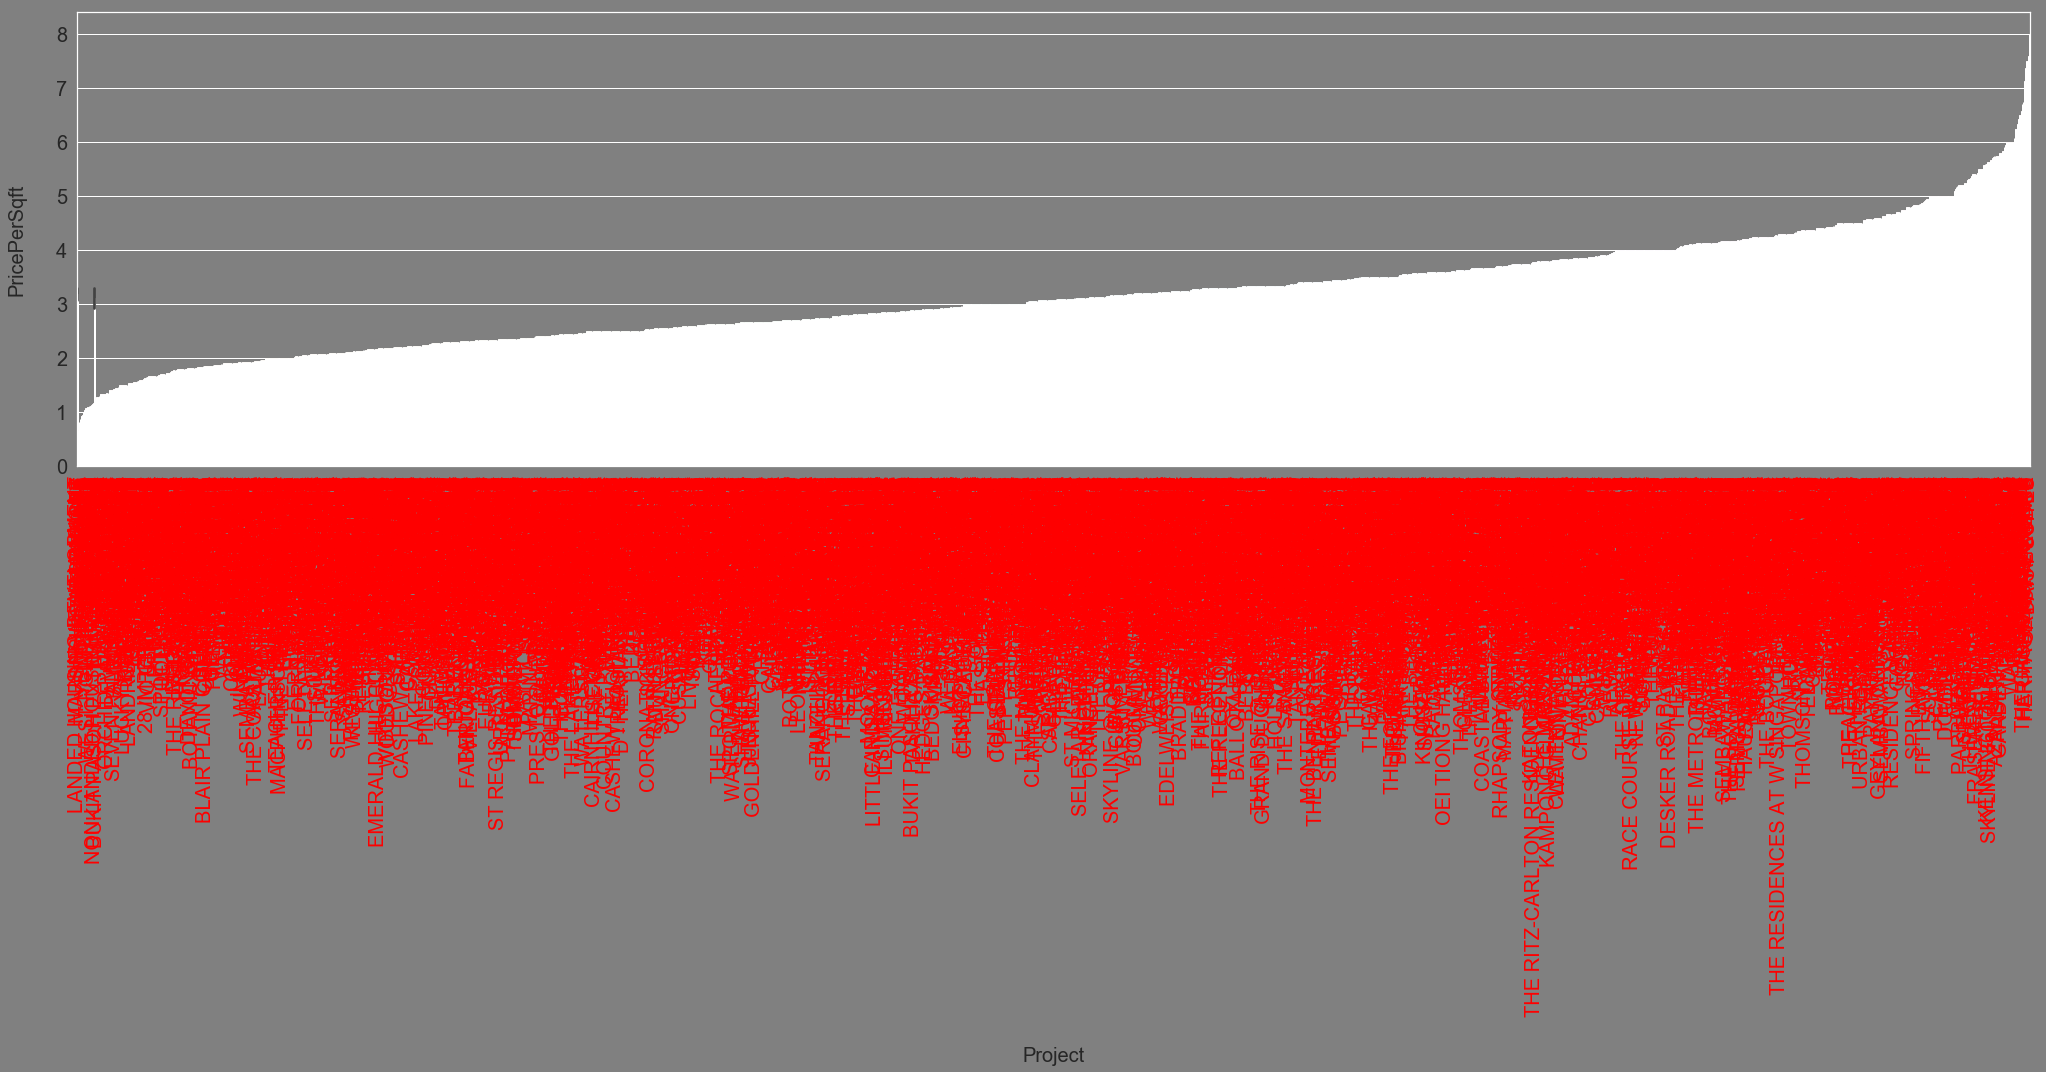

In [20]:
# time to draw the bargraph
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'#808080', 'figure.facecolor':'#808080'})

df_final_pandas = sqlDF.toPandas()
fig = plt.figure(figsize=(35,35))
fig.subplots_adjust(bottom=0.7)
ax = sns.barplot(x="Project", y="PricePerSqft", data=df_final_pandas)
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'cornflowerblue'})



plt.xlabel('Project', size = 20,labelpad=30)
plt.ylabel('PricePerSqft', size = 20, labelpad=30)
plt.xticks(fontsize=20,rotation=90, color='red')
plt.yticks(fontsize=20)
#plt.title('SOR Rates', fontdict = {'fontsize' : 30})
#print(df_final_pandas)
fig.savefig("Rental_unsold_private_Properties.png")
#fig.show()

In [ ]:
df2.printSchema()